To run Atla-Selene-Mini within this notebook, you should use a **GPU with >= 16GB VRAM**. If you are using this notebook within Colab, we recommend changing your Runtime to a **T4 or above** - you can do this by going to `Runtime`→`Change runtime type` and change the `Hardware accelerator`.

# Setup

## Install packages + verify hardware

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Double check you are using a GPU:

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Atla Selene Mini (Model + Tokenizer)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

atla_model_id = "AtlaAI/Selene-1-Mini-Llama-3.1-8B"

atla_model = AutoModelForCausalLM.from_pretrained(atla_model_id, device_map="auto") # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues
atla_tokenizer = AutoTokenizer.from_pretrained(atla_model_id) # set token = <YOUR HUGGINGFACE API KEY> if running into permission issues

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

### Let's test out the model!

In [ ]:
prompt = "I heard you can evaluate my responses?" # replace with your eval prompt

messages = [{"role": "user", "content": prompt}]
text = atla_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = atla_tokenizer([text], return_tensors="pt").to(device)

generated_ids = atla_model.generate(model_inputs.input_ids, max_new_tokens=512, temperature = 0.01, do_sample=True, pad_token_id=atla_tokenizer.eos_token_id)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

response = atla_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


I can provide feedback on your responses in various ways, such as:

1. **Grammar and syntax**: I can check for grammatical errors, suggest corrections, and improve sentence structure.
2. **Clarity**: I can help clarify your thoughts and ensure your message is easy to understand.
3. **Relevance**: I can assess whether your response is relevant to the conversation or topic at hand.
4. **Tone and style**: I can suggest ways to improve the tone and style of your writing to better engage your audience.
5. **Content**: I can evaluate the accuracy and completeness of your information, suggesting additional details or sources when necessary.

Please feel free to share your response, and I'll do my best to provide constructive feedback.


## Load our fine-grained scoring test data

We load test data from the publicly accessible [FLASK](https://arxiv.org/pdf/2307.10928) dataset - a collection of **1,740 human-annotated samples from 120 NLP datasets**. Evaluators assign scores ranging from **1 to 5** for each annotated skill based on the reference (ground-truth) answer and skill-specific scoring rubrics. The paper introduces a taxonomy of 12 metrics suitable for LLM alignment across 4 primary abilities: logical thinking, background knowledge, problem handling, and user alignment.


<br>For this cookbook, we explore `completeness` evaluations within the broader problem handling ability.


<br>We access these test samples from the following [GitHub repo](https://github.com/kaistAI/FLASK).

In [ ]:
import pandas as pd
FLASK_dataset = pd.read_json("https://raw.githubusercontent.com/prometheus-eval/prometheus-eval/refs/heads/main/eval/benchmark/data/flask_eval.json")

# Filter for Completeness criteria scores and get first 25 samples
FLASK_completeness_dataset = FLASK_dataset[FLASK_dataset['criteria'] == 'Completeness'].head(25)

### Process the data

- The user input, assistant response, and reference response are all contained in `instruction` as a json <- **let's extract these into separate columns**
- `human_score` contains 3 different scores across different annotators <- **let's take an average to compare Selene-Mini scores against**

In [ ]:
import re
import numpy as np

def extract_columns(instruction):
    pattern = r"###The instruction to evaluate:(.*?)###Response to evaluate:(.*?)###Reference Answer \(Score 5\):(.*?)###Score Rubrics:"
    matches = re.search(pattern, instruction, re.DOTALL)

    if matches:
        return {
            'user_input': matches.group(1).strip(),
            'assistant_response': matches.group(2).strip(),
            'ground_truth': matches.group(3).strip()
        }
    return None

# Apply the extraction to create new columns
FLASK_completeness_dataset[['user_input', 'assistant_response', 'ground_truth']] = (
    FLASK_completeness_dataset['instruction'].apply(lambda x: pd.Series(extract_columns(x)))
)

# Add human_score mean separately since it comes from a different column
FLASK_completeness_dataset['avg_human_score'] = FLASK_completeness_dataset['human_score'].apply(np.mean)

In [ ]:
FLASK_completeness_dataset.head()

,idx,response_source,criteria,instruction,human_score,gpt4_score,user_input,assistant_response,ground_truth,avg_human_score
10,50,bard,Completeness,###Task Description:\nAn instruction (might in...,"[5, 5, 5]","[4, 4, 4.5]",What are the benefits and challenges of using ...,**Benefits of multilingual approaches in teach...,Benefits of using multilingual approaches in t...,5.000000
29,98,bard,Completeness,###Task Description:\nAn instruction (might in...,"[4, 3, 4]","[4, 5, 4]",Why did the building of a pipeline have to be ...,The building of a pipeline is a major infrastr...,"The building of a pipeline, such as the Keysto...",3.666667
38,149,bard,Completeness,###Task Description:\nAn instruction (might in...,"[5, 5, 5]","[4, 5, 4]",What is the relationship between sleep apnea a...,**Relationship between sleep apnea and cardiov...,Sleep apnea is a sleep disorder characterized ...,5.000000
57,76,bard,Completeness,###Task Description:\nAn instruction (might in...,"[5, 4, 5]","[4, 3, 3]",ideas for building a waitlist for a new produc...,Here are some ideas for building a waitlist fo...,1. Landing page: Create an attractive and info...,4.666667
62,128,bard,Completeness,###Task Description:\nAn instruction (might in...,"[2, 1, 1]","[1, 1, 1]",Introduce the ”financial markets and instituti...,I do not have enough information about that pe...,"""Financial Markets and Institutions"" by Freder...",1.333333


## Define our Completeness evaluation prompt

We define a completeness evaluation prompt to use with our model. Please refer to our [prompts](https://www.link.com) folder on GitHub for the prompt templates we used when training our model.

In [ ]:
completeness_eval_prompt = """You are tasked with evaluating a response based on a given instruction (which may contain an Input) and a scoring rubric and reference answer that serve as the evaluation standard. Provide a comprehensive feedback on the response quality strictly adhering to the scoring rubric, without any general evaluation. Follow this with a score between 1 and 5, referring to the scoring rubric. Avoid generating any additional opening, closing, or explanations.

  Here are some rules of the evaluation:
  (1) You should prioritize evaluating whether the response satisfies the provided rubric. The basis of your score should depend exactly on the rubric. However, the response does not need to explicitly address points raised in the rubric. Rather, evaluate the response based on the criteria outlined in the rubric.

  Your reply should strictly follow this format:
  **Reasoning:** <Your feedback>

  **Result:** <an integer between 1 and 5>

  Here is the data:

  Instruction:
  ```
  {user_input}
  ```

  Response:
  ```
  {assistant_response}
  ```

  Score Rubrics:
  Does the response provide a sufficient explanation? Comprehensiveness and thoroughness of the response should be considered, which depends on the breadth of
  topics covered and the level of detail provided within each topic.
  Score 1: The response doesn’t include any specifics or examples to support the statements
  made.
  Score 2: The response does not provide sufficient details or supportive examples, requiring
  a major effort to make the response more complete.
  Score 3: It is a decent response, but the breadth and depth of the response are rather limited.
  The details and examples used to substantiate the response may be insufficient.
  Score 4: The response provides detailed explanations, but there is room for enhancement.
  The response could be further improved by including more details and supportive examples.
  Score 5: The response fully provides comprehensive explanations. It delves deep into the
  topic, providing as much detail as possible, and it offers several examples to back up its
  points.

  Reference answer:
  {ground_truth}"""

### Define function to format prompt with input variables

In [ ]:
import json

def build_evaluation_prompt(df, prompt, assistant_response_col, user_input_col, ground_truth_col=None, row_index=0):

    if assistant_response_col not in df.columns:
        raise ValueError(f"Missing required column: {assistant_response_col}")

    if user_input_col not in df.columns:
        raise ValueError(f"Missing required column: {user_input_col}")

    if row_index >= len(df):
        raise ValueError(f"Row index {row_index} is out of bounds")

    # Extract response and input
    assistant_response = df[assistant_response_col].iloc[row_index]
    user_input = df[user_input_col].iloc[row_index]

    # Extract ground truth if column is provided
    ground_truth = ""
    if ground_truth_col and ground_truth_col in df.columns:
        ground_truth = df[ground_truth_col].iloc[row_index]

    # Parse source_info (if JSON-like) for user_input to avoid errors
    if isinstance(user_input, str) and user_input.startswith("{"):
        try:
            user_input = json.loads(user_input).get("question", user_input)
        except json.JSONDecodeError:
            pass

    # Format the prompt
    return prompt.format(
        user_input=user_input,
        assistant_response=assistant_response,
        ground_truth=ground_truth
    )

In [ ]:
prompt = build_evaluation_prompt(
     df=FLASK_completeness_dataset,
     user_input_col='user_input',
     assistant_response_col='assistant_response',
     ground_truth_col='ground_truth',
     prompt=completeness_eval_prompt,
     row_index=0)

## Define evaluation function

In [ ]:
def evaluate(prompt, model, tokenizer, device=device, temperature=0.01, max_new_tokens=512):

    try:
        # Format the prompt into messages
        messages = [{"role": "user", "content": prompt}]

        # Apply chat template
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        # Prepare model inputs
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        # Generate response
        generated_ids = model.generate(
            model_inputs.input_ids,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

        # Extract the newly generated tokens
        generated_ids = [
            output_ids[len(input_ids):]
            for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        # Decode the response
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        return response

    except Exception as e:
        print(f"Error in evaluate function: {e}")
        return None

Here's an example Selene-Mini response based on the prompt above:

In [ ]:
evaluate(prompt=prompt, model=atla_model, tokenizer=atla_tokenizer)

"**Reasoning:** The response lacks specific details and examples to support its statements, making it difficult to understand the context and relevance of the user input. To improve, the assistant should provide concrete examples or explanations that directly relate to the user's input, enhancing the comprehensiveness of the response. Additionally, the assistant could benefit from elaborating on the implications or potential outcomes of the user input, which would add depth to the explanation. Overall, the response is too vague and does not meet the criteria for a score of 2 or higher.\n\n**Result:** 1"

### Define function to evaluate over a dataframe:

In [ ]:
from tqdm import tqdm

def evaluate_df(df, prompt, model, tokenizer, assistant_response_col, user_input_col,
                ground_truth_col=None, output_critique_col='atla_critique',
                output_score_col='atla_score'):

    # Create a copy of df
    df_evaluated = df[df['idx'].notna()].copy()

    # Initialize score and critique columns
    df_evaluated[output_critique_col] = None
    df_evaluated[output_score_col] = None

    # Evaluate over the df
    for index, row in tqdm(df_evaluated.iterrows(), desc="Evaluating responses", total=len(df_evaluated)):
        try:
            evaluation_prompt = build_evaluation_prompt(
                df=df_evaluated,
                prompt=prompt,
                assistant_response_col=assistant_response_col,
                user_input_col=user_input_col,
                ground_truth_col=ground_truth_col,
                row_index=df_evaluated.index.get_loc(index)
            )

            response = evaluate(evaluation_prompt, model, tokenizer)
            critique, score = parse_atla_response(response)

            df_evaluated.at[index, output_critique_col] = critique
            df_evaluated.at[index, output_score_col] = score

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    return df_evaluated

## Define response parsing function

Atla has been trained to return evaluations in the following format:
```
  **Reasoning:** <Feedback>

  **Result:** <Score>
```

Let's define a parsing function to extract the reasoning and the score from the response.

In [ ]:
def parse_atla_response(response):
    """
    Parse ATLA model response to extract reasoning and score.

    Args:
        response (str): Raw response from ATLA model

    Returns:
        tuple: (critique, score) where critique is a string and score is an integer
    """
    try:
        # Split into lines and clean up
        lines = [line.strip() for line in response.split('\n') if line.strip()]

        # Extract critique (everything between **Reasoning:** and **Result:**)
        critique = None
        score = None

        for i, line in enumerate(lines):
            if line.startswith("**Reasoning:**"):
                critique = lines[i].replace("**Reasoning:**", "").strip()
            elif line.startswith("**Result:**"):
                score = int(lines[i].replace("**Result:**", "").strip())

        # Remove style tag if present
        if critique and "<userStyle>" in critique:
            critique = critique.split("<userStyle>")[0].strip()

        return critique, score

    except Exception as e:
        print(f"Error parsing ATLA response: {e}")
        return None, None

# Start running evals

In [ ]:
df_evaluated = evaluate_df(df=FLASK_completeness_dataset,
            prompt=completeness_eval_prompt,
            model=atla_model,
            tokenizer=atla_tokenizer,
            user_input_col='user_input',
            assistant_response_col='assistant_response',
            ground_truth_col='ground_truth'
            )

Evaluating responses: 100%|██████████| 25/25 [02:57<00:00,  7.11s/it]


### Let's see how the model did compared to the average human score:

**High Degree:** Values between 0.50 and 1 suggest a strong correlation.

**Moderate Degree:** Values between 0.30 and 0.49 indicate a moderate correlation.

**Low Degree:** Values below 0.29 are considered a weak correlation.

In [ ]:
from scipy import stats

correlation, p_value = stats.pearsonr(df_evaluated['atla_score'], df_evaluated['avg_human_score'])
print(f"Pearson correlation: {correlation:.3f}")

Pearson correlation: 0.693


# Results Plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

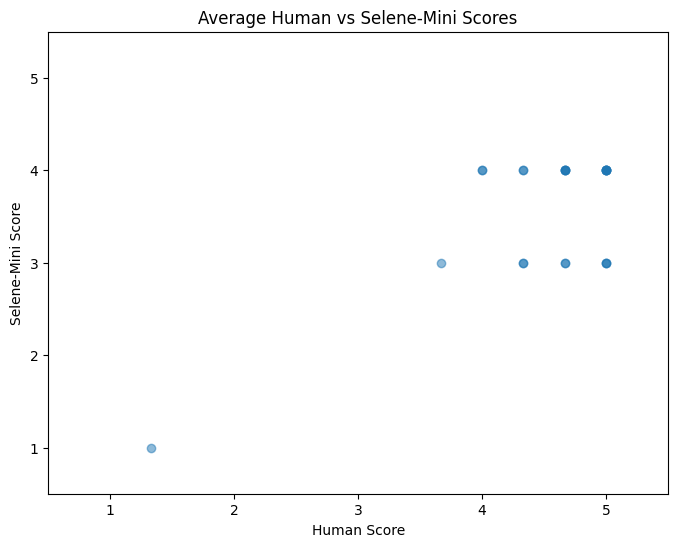

In [ ]:
# Distribution plot of human vs. Selene-Mini scores

plt.figure(figsize=(8, 6))
plt.scatter(df_evaluated['avg_human_score'],
           df_evaluated['atla_score'],
           alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.title('Average Human vs Selene-Mini Scores')
plt.xlabel('Human Score')
plt.ylabel('Selene-Mini Score')
plt.show()